In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import time
from collections import Counter

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [ ]:

# Image transformations: preprocessing + augmentation
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load datasets
train_data = datasets.ImageFolder("C:\Users\Papince Gupta\OneDrive\Desktop\semester 6\SE\project\Nidaan_AI\brain_tumor_mri_dataset/Training", transform=train_transform)
val_data = datasets.ImageFolder("C:\Users\Papince Gupta\OneDrive\Desktop\semester 6\SE\project\Nidaan_AI\brain_tumor_mri_dataset/Testing", transform=val_transform)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)


In [3]:

# Load pretrained ResNet-50
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)


In [4]:

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze layer4 for fine-tuning
for name, param in model.named_parameters():
    if "layer4" in name:
        param.requires_grad = True

# Replace final fc layer
num_classes = 4
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Handle class imbalance
targets = [label for _, label in train_data.samples]
class_counts = Counter(targets)
class_weights = [1.0 / class_counts[i] for i in range(num_classes)]
weights_tensor = torch.FloatTensor(class_weights).to(device)

criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)



In [5]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [6]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())

2.6.0+cu124
True
1


In [7]:
# Training & Validation loops
num_epochs = 6

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    scheduler.step()
    train_acc = correct / total

    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    val_acc = val_correct / val_total

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {running_loss/len(train_loader):.4f} "
          f"Train Acc: {train_acc:.4f} "
          f"Val Acc: {val_acc:.4f}")

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=train_data.classes))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)


Epoch [1/6] Train Loss: 0.4552 Train Acc: 0.8275 Val Acc: 0.8622
Epoch [2/6] Train Loss: 0.2773 Train Acc: 0.8945 Val Acc: 0.9062
Epoch [3/6] Train Loss: 0.2381 Train Acc: 0.9116 Val Acc: 0.8839
Epoch [4/6] Train Loss: 0.2038 Train Acc: 0.9223 Val Acc: 0.9091
Epoch [5/6] Train Loss: 0.1748 Train Acc: 0.9338 Val Acc: 0.9220
Epoch [6/6] Train Loss: 0.1541 Train Acc: 0.9428 Val Acc: 0.9337

Classification Report:

              precision    recall  f1-score   support

      glioma       0.94      0.89      0.91       400
  meningioma       0.94      0.90      0.92       421
     notumor       0.90      0.99      0.94       510
   pituitary       0.98      0.95      0.96       374

    accuracy                           0.93      1705
   macro avg       0.94      0.93      0.93      1705
weighted avg       0.94      0.93      0.93      1705


Confusion Matrix:
 [[354  13  33   0]
 [ 21 380  13   7]
 [  2   3 504   1]
 [  1   9  10 354]]


In [31]:
from torchvision import transforms
from PIL import Image
import torch

def predict_image(model, img_path, transform, device, class_names):
    """
    Predict the class of an image using the trained model.

    Args:
        model (torch.nn.Module): Trained model.
        img_path (str): Path to input image.
        transform (torchvision.transforms.Compose): Image preprocessing.
        device (torch.device): CPU or CUDA.
        class_names (list): List of class labels.

    Returns:
        str: Predicted class label.
    """
    model.eval()  # Set model to evaluation mode

    # Load and preprocess image
    image = Image.open(img_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(img_tensor)
        _, preds = torch.max(outputs, 1)

    predicted_class = class_names[preds.item()]
    return predicted_class


In [35]:
torch.save(model.state_dict(), "brain_tumor_resnet50.pth")

In [ ]:
# Assuming you have these class labels in order
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

img_path = "C:\Users\Papince Gupta\OneDrive\Desktop\semester 6\SE\project\Nidaan_AI\brain_tumor_mri_dataset/Training/glioma/Tr-gl_1150.jpg"

prediction = predict_image(model, img_path, val_transform, device, class_names)

print(f"Predicted class: {prediction}")


Predicted class: glioma


In [37]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision import transforms
from PIL import Image
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_gradcam(model, img_path, target_layer, transform, device):
    """
    Apply Grad-CAM and visualize heatmap overlay for a given image and model.

    Args:
        model (torch.nn.Module): Trained model.
        img_path (str): Path to input image.
        target_layer (torch.nn.Module): Target layer for Grad-CAM.
        transform (torchvision.transforms.Compose): Transformations to apply.
        device (torch.device): Device to run on.

    Returns:
        None (displays heatmap overlay plot)
    """
    # Load and preprocess image
    pil_image = Image.open(img_path).convert("RGB")
    input_tensor = transform(pil_image).unsqueeze(0).to(device)

    # Convert image to numpy for overlay (normalized 0-1)
    np_img = np.array(pil_image).astype(np.float32) / 255.0

    # Resize numpy image to match model input size from transform
    target_size = transform.transforms[0].size  # expects a tuple like (224, 224)
    np_img_resized = cv2.resize(np_img, target_size)


    # Set up Grad-CAM
    cam = GradCAM(model=model, target_layers=[target_layer])
    grayscale_cam = cam(input_tensor=input_tensor)[0, :]

    # Overlay CAM on resized image
    visualization = show_cam_on_image(np_img_resized, grayscale_cam, use_rgb=True)

    # Plot the result
    plt.figure(figsize=(8, 8))
    plt.imshow(visualization)
    plt.title("Grad-CAM Heatmap Overlay")
    plt.axis('off')
    plt.show()


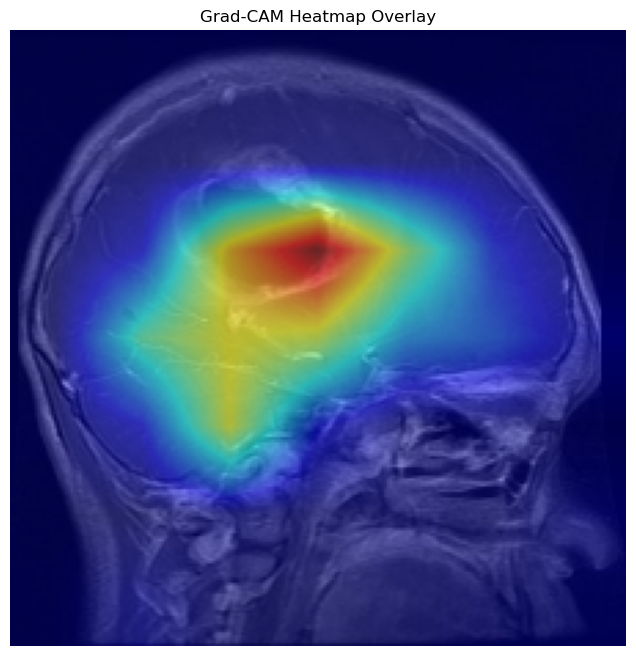

In [ ]:
target_layer = model.layer4[-1]  # for ResNet50's last bottleneck
img_path = "C:\Users\Papince Gupta\OneDrive\Desktop\semester 6\SE\project\Nidaan_AI\brain_tumor_mri_dataset/Training/glioma/Tr-gl_1104.jpg"

visualize_gradcam(
    model=model,
    img_path=img_path,
    target_layer=target_layer,
    transform=val_transform,
    device=device
)
